## Transfer learning with ResNet101 for the Ginger3 Dataset (but with PyTorch instead of Tensorflow)

Based on this tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### Imports

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
torch.__version__

'0.4.1'

In [3]:
torch.cuda.is_available()

True

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'ginger_tri_256x256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,
                                             shuffle=True, num_workers=3)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

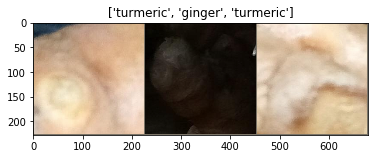

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
classes

tensor([2, 1, 2])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
resnet_model = models.resnet50(pretrained=True)

#newmodel = torch.nn.Sequential(*(list(resnet_model.children())[:-2]))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/mmcateer0/.torch/models/resnet50-19c8e357.pth
38.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

67.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

95.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_

In [10]:
model_ft = nn.Sequential(resnet_model,
                         #nn.AvgPool2d(resnet_model.fc.out_features),
                         nn.Linear(resnet_model.fc.out_features, 128),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(128, 3),
                         nn.Softmax())


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=35, gamma=0.1)

In [11]:
model_ft[-1]

Softmax()

In [12]:
#%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/lib/python3/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 0.9745 Acc: 0.5849
test Loss: 0.7423 Acc: 0.8973

Epoch 1/29
----------
train Loss: 0.8253 Acc: 0.7444
test Loss: 0.6455 Acc: 0.9267

Epoch 2/29
----------
train Loss: 0.7716 Acc: 0.7827
test Loss: 0.6749 Acc: 0.8893

Epoch 3/29
----------
train Loss: 0.7406 Acc: 0.8142
test Loss: 0.6516 Acc: 0.9013

Epoch 4/29
----------
train Loss: 0.7086 Acc: 0.8489
test Loss: 0.6302 Acc: 0.9147

Epoch 5/29
----------
train Loss: 0.7084 Acc: 0.8444
test Loss: 0.5964 Acc: 0.9627

Epoch 6/29
----------
train Loss: 0.7031 Acc: 0.8489
test Loss: 0.6369 Acc: 0.9160

Epoch 7/29
----------
train Loss: 0.6853 Acc: 0.8702
test Loss: 0.6258 Acc: 0.9373

Epoch 8/29
----------
train Loss: 0.6808 Acc: 0.8689
test Loss: 0.6127 Acc: 0.9413

Epoch 9/29
----------
train Loss: 0.6834 Acc: 0.8671
test Loss: 0.5958 Acc: 0.9533

Epoch 10/29
----------
train Loss: 0.6728 Acc: 0.8778
test Loss: 0.6036 Acc: 0.9480

Epoch 11/29
----------
train Loss: 0.6556 Acc: 0.8964
test Loss: 0.6098 Acc: 0.9427

Epoch 12/29


/usr/lib/python3/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


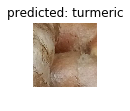

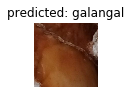

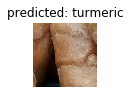

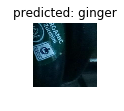

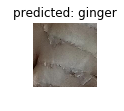

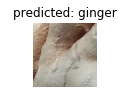

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc18d0dfb38>>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/lib/python3/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 153, in recvfds
    msg, ancdata, 

In [13]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [14]:
resnet_model_lr = torchvision.models.resnet50(pretrained=True)
resnet_model_lr.parameters()

<generator object Module.parameters at 0x7fc18d0c39e8>

In [15]:
resnet_model_lr = torchvision.models.resnet50(pretrained=True)
for param in resnet_model_lr.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv = nn.Sequential(resnet_model_lr,
                         #nn.AvgPool2d(resnet_model.fc.out_features),
                         nn.Linear(resnet_model_lr.fc.out_features, 128),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(128, 3),
                         nn.Softmax())

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=35, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


/usr/lib/python3/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 1.0426 Acc: 0.4849
test Loss: 0.9096 Acc: 0.7040

Epoch 1/29
----------
train Loss: 0.9481 Acc: 0.6347
test Loss: 0.8265 Acc: 0.7827

Epoch 2/29
----------
train Loss: 0.9044 Acc: 0.6773
test Loss: 0.8138 Acc: 0.7667

Epoch 3/29
----------
train Loss: 0.8764 Acc: 0.6911
test Loss: 0.7704 Acc: 0.8160

Epoch 4/29
----------
train Loss: 0.8602 Acc: 0.7049
test Loss: 0.7746 Acc: 0.7893

Epoch 5/29
----------
train Loss: 0.8369 Acc: 0.7356
test Loss: 0.7585 Acc: 0.8053

Epoch 6/29
----------
train Loss: 0.8223 Acc: 0.7467
test Loss: 0.7206 Acc: 0.8507

Epoch 7/29
----------
train Loss: 0.8107 Acc: 0.7604
test Loss: 0.7272 Acc: 0.8467

Epoch 8/29
----------
train Loss: 0.8132 Acc: 0.7436
test Loss: 0.7220 Acc: 0.8453

Epoch 9/29
----------
train Loss: 0.8151 Acc: 0.7431
test Loss: 0.7283 Acc: 0.8373

Epoch 10/29
----------
train Loss: 0.8008 Acc: 0.7604
test Loss: 0.7204 Acc: 0.8373

Epoch 11/29
----------
train Loss: 0.8064 Acc: 0.7444
test Loss: 0.6922 Acc: 0.8707

Epoch 12/29


/usr/lib/python3/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


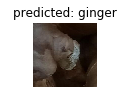

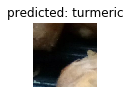

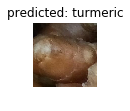

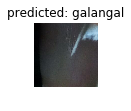

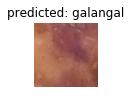

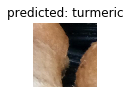

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Saving and loading models

In [18]:
#torch.save(model_ft.state_dict(), "model_ft.pth")
torch.save(model_ft, "model_ft.pt")

In [19]:
#torch.save(model_conv.state_dict(), "model_conv.pth")
torch.save(model_conv, "model_conv.pt")

In [23]:
# Model class must be defined somewhere
model_ft2 = torch.load("model_ft.pt")
model_ft2.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [24]:
# Model class must be defined somewhere
model_conv2 = torch.load("model_conv.pt")
model_conv2.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


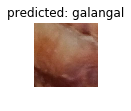

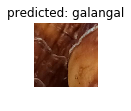

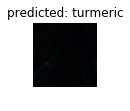

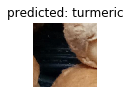

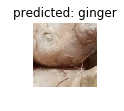

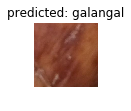

In [25]:
visualize_model(model_ft2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


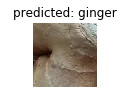

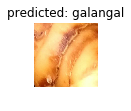

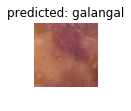

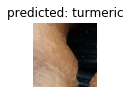

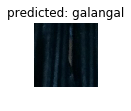

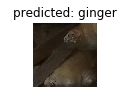

In [26]:
visualize_model(model_conv2)